# Gaussian Mixture Model

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import seaborn as sns

## Basic concepts

<AxesSubplot:ylabel='Count'>

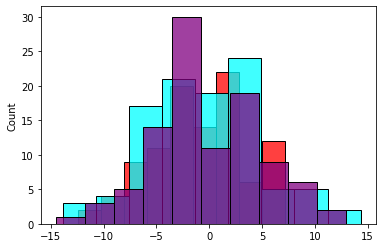

In [55]:
# Example data
a = np.random.normal(0, 5, 100).round(2)
b = np.random.normal(0, 5, 100).round(2)
c = np.random.normal(0, 5, 100).round(2)

sns.histplot(a, color='red')
sns.histplot(b, color='cyan') 
sns.histplot(c, color='purple') 

### Covariance matrix

In [56]:
# Set up the general case.
def variation(array_a, array_b):
    mean_a = array_a.mean()
    mean_b = array_b.mean()
    x = 1 / (len(array_a) - 1) * sum((array_a - mean_a) * (array_b - mean_b))
    print(x)

In [57]:
# Variance: how much a sample varies.
variation(a, a)

np.var(a, ddof=1)

19.712449656565653


19.712449656565656

In [58]:
# Covariance: how much two samples varies together.
variation(a, b)

np.cov(a, b)

-2.686434606060605


array([[19.71244966, -2.68643461],
       [-2.68643461, 29.47580819]])

In [59]:
# Covariance matrix: how much multiple samples varies together
abc = np.stack([a, b, c], axis=1)
np.cov(abc.T)

array([[19.71244966, -2.68643461, -0.27344127],
       [-2.68643461, 29.47580819,  0.04766637],
       [-0.27344127,  0.04766637, 26.26351243]])

### Multivariate gaussian

$f(x) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}}
       \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$

In [165]:
# Example data
mean_array = np.array([a.mean(), b.mean()])
display(mean_array)

ab = np.stack([a, b], axis=1)
cov_matrix = np.cov(ab.T)
display(cov_matrix)

array([-0.9478, -0.4067])

array([[19.71244966, -2.68643461],
       [-2.68643461, 29.47580819]])

In [161]:
def gaussian_prob_density_function(array, mean, cov):
    size = len(array)
    escalar_part = 1/((2 * np.pi) ** size * np.linalg.det(cov)) ** (1/2)
    exp_part = np.exp(-1/2 * np.matmul(np.matmul((array - mean).reshape(1, size), np.linalg.inv(cov)), array - mean))
    pdf = escalar_part * exp_part

    return pdf[0]

gaussian_prob_density_function(array=ab[0], mean=mean_array, cov=cov_matrix)

0.0054051044978481845

In [166]:
# Check
mg = multivariate_normal(mean=mean_array, cov=cov_matrix)
mg.pdf(ab[0])

0.005405104497848185

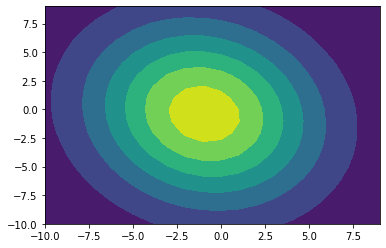

In [167]:
x, y = np.mgrid[-10:10:1, -10:10:1]
pos = np.dstack((x, y))
mn = multivariate_normal(mean=mean_array, cov=cov_matrix)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, mn.pdf(pos))

## Experimenting on 2D

### Normal distributed variables

In [37]:
mean_a = 
var_a = 2

mean_b = 5
var_b = 2

size = 500

dist_a = np.random.normal(mean_a, var_a, size)
dist_b = np.random.normal(mean_b, var_b, size)
#dataset_ab = np.array([dist_a, dist_b])

<AxesSubplot:>

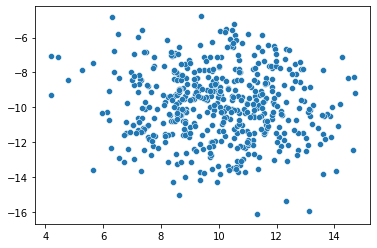

In [38]:
sns.scatterplot(x=dist_a, y=dist_b)

<AxesSubplot:ylabel='Count'>

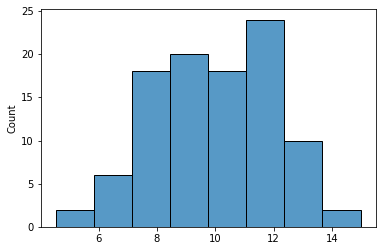

In [8]:
sns.histplot(dist_a)

In [ ]:
def multi_gaussian(array_mean, array_var)

In [ ]:

def gaussian_pdf(x, mu, sigma):
    # x vector should be in column, but numpy treat 1-d array as vector so can save the extra step
    n = len(x)
    return (2*np.pi)**(-n/2) * (np.linalg.det(sigma) ** (-1/2) ) * np.exp(-1/2*((x-mu).T@np.linalg.inv(sigma)@(x-mu)))

### Non-normal distributed variables

### High correlated variables

### Non correlated variables